In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

Per the course AI usage policy, I must say that I relied on chatgpt for help with processing the data from these unfamiliar files. However, I've taken lots of time to understand the process and change things to my needs, so the comments should reflect this and make it easy to read. 

The dataset takes ~5 minutes or less to read through and make into useable training and testing data



In [4]:
# Only include chords that are major or minor (ignores maj7, dim, aug, sus, etc.)
VALID_QUALITIES = ['maj', 'min']

# Initialize lists to store mean chroma features over time (X) and chord labels (y)
X = []
y = []

# Define folder where the dataset is stored
data_path = "data/mcgill-billboard"

# Find paths to chord annotations and chroma metadata folders
annotation_dir = os.path.join(data_path, "annotations", "annotations")
metadata_dir = os.path.join(data_path, "metadata", "metadata")

# Make a list of every annotated track folder (one folder per track, e.g. 0003)
track_list = os.listdir(annotation_dir)

# Loop through every track folder in the annotation directory 
for track_id in tqdm(track_list):  # tqdm shows progress bar
    try:
        # Paths to the annotation and chroma data for this track
        lab_path = os.path.join(annotation_dir, track_id, "majmin.lab")
        chroma_path = os.path.join(metadata_dir, track_id, "bothchroma.csv")

        # If either file is missing, skip this track
        if not os.path.exists(lab_path) or not os.path.exists(chroma_path):
            continue

        # Read chroma CSV into a DataFrame
        df = pd.read_csv(chroma_path, header=None)

        # Drop any rows with NaN values
        df.dropna()

        # Name the columns: first 3 are metadata (audio path, time, duration)
        # The rest are assumed to be chroma values, named chroma_0 to chroma_11
        df.columns = ["audio_path", "time", "duration"] + [f"chroma_{i}" for i in range(df.shape[1] - 3)]

        # Open and read each line from the chord label file
        with open(lab_path, "r") as f:
            for line in f:
                # Split line into start time, end time, and label e.g., "0.000 1.500 C:maj"
                parts = line.strip().split()
                if len(parts) != 3:
                    continue  # skip malformed lines, should only have 3 parts

                start, end, label = parts

                # Skip labels that don’t include “:” (like "N" or malformed entries)
                if ':' not in label:
                    continue

                # Split chord quality from root (e.g., "C:maj" → "C", "maj"), then check if valid
                root, quality = label.split(':', 1)
                if quality not in VALID_QUALITIES:
                    continue

                # Convert start and end times to float from strings
                start = float(start)
                end = float(end)

                # Select only chroma rows whose timestamps fall within the current chord segment
                segment = df[(df["time"] >= start) & (df["time"] < end)]

                # If no chroma rows are found for this time range, skip it
                if len(segment) == 0:
                    continue

                # Define the 12 chroma pitch class columns (C, C#, ..., B)
                chroma_cols = [f"chroma_{i}" for i in range(12)]

                # Compute the mean chroma across the selected time range
                chroma_mean = segment[chroma_cols].mean().values

                X.append(chroma_mean)
                y.append(label)  # full label, e.g., "C:maj"

    except Exception as e:
        # Print the error if something goes wrong with this track
        print(f"Error with track {track_id}: {e}")

  0%|          | 0/890 [00:00<?, ?it/s]

100%|██████████| 890/890 [02:52<00:00,  5.17it/s]


### Split Data

In [ ]:
X = np.array(X)
y = np.array(y)

# Split data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train Model - Random Forest

In [ ]:
# Create and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)
print("Random Forest Classifier Classification Report:")
print(classification_report(y_test, y_pred))

Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

       A:maj       0.72      0.85      0.78      1985
       A:min       0.77      0.52      0.62       764
      Ab:maj       0.74      0.87      0.80       890
      Ab:min       0.91      0.42      0.58        73
       B:maj       0.76      0.79      0.77       857
       B:min       0.78      0.71      0.74       618
      Bb:maj       0.81      0.84      0.82      1186
      Bb:min       0.91      0.65      0.76       189
      C#:maj       0.81      0.22      0.35        58
      C#:min       0.81      0.74      0.77       288
       C:maj       0.80      0.86      0.83      2186
       C:min       0.85      0.45      0.59       358
      Cb:maj       0.92      0.52      0.67        44
      D#:maj       1.00      0.71      0.83         7
      D#:min       0.86      0.15      0.26        40
       D:maj       0.77      0.84      0.81      2162
       D:min       0.80      0.55

### Confusion Matrix - Random Forest

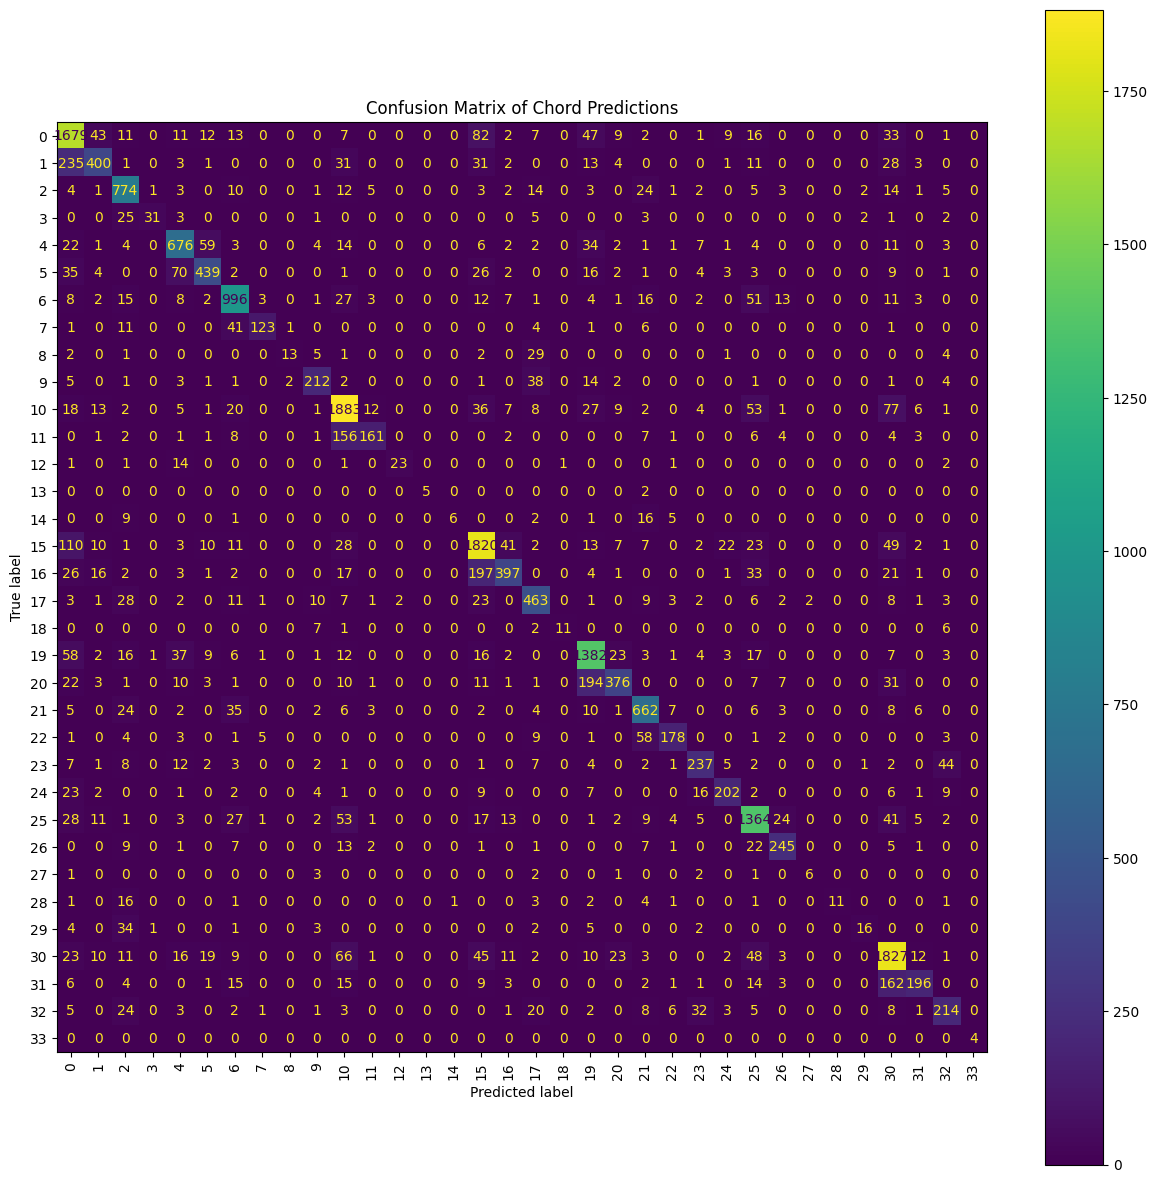

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(15, 15))
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title("Confusion Matrix of Chord Predictions")
plt.show()

### Train Model - Decision Tree

In [ ]:
# Create and train the model
model = DecisionTreeClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)
print("Decision Tree Classifier Classification Report:")
print(classification_report(y_test, y_pred))

### Confusion Matrix - Decision Tree

## Analysis

### Use Case
This will probably be most useful in times where you know a chord change happens, but can't tell what it is